In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [64]:
# Generate data
# make_circles表示生成圓形分布的資料集，為一種二元分類
# n_sample表示生成數量，此處生成一百筆
# factor表示尺度因子，值越大，生成的圓形會越大
# noise表示生成資料點的雜訊水平，值越大，點越離散
# circles_data包含一百個資料點的二維陣列，每個資料點有兩個特徵(維度)，分別代表x和y軸
# circles_data_labels則是包含100個標籤的一維陣列，表示每個資料點的類別，類別只會有兩個
circles_data, circles_data_labels = datasets.make_circles(n_samples=100, factor=0.1, noise=0.1)

In [65]:
# Split data into training and testing sets
# 70%訓練，30%測試
# x是特徵資料，二維
# y是標籤，一維
X_train, X_test, y_train, y_test = train_test_split(circles_data, circles_data_labels, test_size=0.3, random_state=42)

In [66]:
# Normalize the data
# 對資料進行縮放，將特徵放到相同的尺度，可以讓模型便比較穩定和收斂，此步驟可做可不做
# 正規化之後，特徵差異會變小，這樣應該會比較集中在中心的位置
# 不做正規化的特徵差異會比較明顯，不同類別之間的邊界會更明確和清楚
"""
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
"""

# Convert data to PyTorch tensors
# 神經網路模型訓練之前，要先轉換成pytorch的資料型態tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [67]:
# Define the neural network architecture
# forward函數，輸出是對於給定輸入的預測結果
# relu函數，輸入大於0，返回輸入值本身，輸入小於0，返回0
# sigmoid函數，輸出介於0到1之間
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize the neural network
model = NeuralNetwork()

# Define loss function and optimizer
# 二元交叉熵損失函數是用於二元分類問題
# lr學習率，通常設成0.001或0.01，太小會導致訓練速度過慢，太大會導致訓練不足或無法收斂
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Convert data to PyTorch dataset
# 將資料分成小批次進行訓練，並且可以自動劃分小批次進行訓練
# batch_size指定每個小批次中包含的樣本數量
# shuffle是布林值，表示在每個epoch是否打亂資料集，打亂有助於模型更好學習，能確保在每個小批次中看到的樣本是隨機的
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [69]:
# Train the neural network
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad() # 在每個小批次的開始，將優化器的梯度緩衝區清零，以確保每個小批次的梯度都是獨立計算的
        outputs = model(inputs) #正向傳播，得到模型預設的輸出，可以看作是從輸入到輸出的前進流動
        loss = criterion(outputs, targets.view(-1, 1)) # 計算模型輸出與真實targets之間的損失
        loss.backward() #反向傳播，將損失信號從輸出層向後傳到輸入層，計算每個參數對損失的貢獻度，可以看作是從損失到模型參數的反向傳遞。通過這個過程，我們可以計算每個參數應該如何調整，以減小損失
        optimizer.step() # 使用優化器更新模型參數

# Evaluate the trained model
# 轉成評估模式
# 用測試資料進行預測，輸出為pytorch張量
# predicted是對測試集中的特徵資料進行預設得到的結果，用於評估模型的性能和準確度等
model.eval()
with torch.no_grad():
    predicted = model(X_test_tensor)

    # Accuracy
    # 將模型的預測轉換為類別
    # 假設使用的是二元分類，閾值為0.5
    predicted_classes = (predicted > 0.5).float()

    # 將預測類別展平為一維陣列
    predicted_classes = predicted_classes.flatten()
    
    # 將真實類別展平為一維陣列
    y_test = y_test.flatten()

# 將預測類別與真實類別進行比較
# Compare predicted classes with true classes
correct = (predicted_classes == y_test).sum().item()

# 計算準確率
accuracy = correct / len(y_test)
print(f'Accuracy: {accuracy}')

AttributeError: 'bool' object has no attribute 'sum'

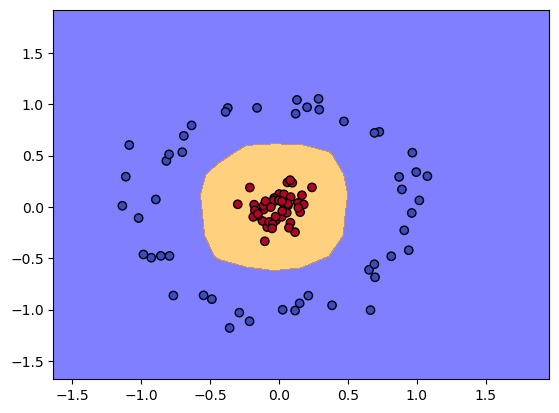

In [70]:
# Visualize the data and decision boundary
# 計算x軸和y軸的範圍，也就是調整邊界，為了在繪製決策邊界時留出一些額外的空間
# circles_data[:, 0]表示取所有行的第一列，也就是第一個特徵值的數組
# circles_data[:, 1]表示取所有行的第二列，也就是第二個特徵值的數組
x_min, x_max = circles_data[:, 0].min() - 0.5, circles_data[:, 0].max() + 1
y_min, y_max = circles_data[:, 1].min() - 0.5, circles_data[:, 1].max() + 1

# 創建網格，用於在整個特徵空間計算模型的預測
# 步長為0.2，表示x和y軸上坐標點之間的間隔
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))

# 計算模型在整個特徵空間上的預測結果
# 描述模型在整個特徵空間中的決策邊界，並且將預測結果轉換為numpy陣列
# np.c_[xx.ravel(), yy.ravel()]將二維陣列展平為一維，返回值是一個二維的numpy陣列
# torch.tensor將二維的numpy陣列轉維pytorch的張量，為了將這些點坐標輸入到模型中進行預測
# detach()分離張量，將其從計算圖中分離出來，使得在反向傳播時不會計算其梯度，可以幫助pytorch更快轉換成numpy
# numpy() 進行可視化之前，先轉成numpy
# reshape(xx.shape)將一維的預測結果重新弄成與網格維度相同的矩陣
Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).detach().numpy().reshape(xx.shape)

# 繪製等高線圖
# contourf用來填充等高線圖的區域
# xlim和ylim設定x軸和y軸的範圍
plt.contourf(xx, yy, Z, alpha=0.5, levels=[0, 0.5, 1], colors=('blue', 'orange'))
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# 在座標軸上繪製散點
# c=circles_data_labels，使用這個類別來區分散點的顏色
plt.scatter(circles_data[:, 0], circles_data[:, 1], c=circles_data_labels, cmap='coolwarm', edgecolors='k')

plt.show()